# Prepare

In [1]:
import os, yaml, random, uproot, json, correctionlib
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import scipy as sp
import scipy.stats as sps
from scipy.interpolate import CubicSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh

/afs/cern.ch/user/d/dfu/.local/lib/python3.9/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/afs/cern.ch/user/d/dfu/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/afs/cern.ch/user/d/dfu/.local/lib/python3.9/site-packages/

In [2]:
tagger_cut = {
    'down': {'SR1': 0.8, 'SR2': 0.98},
    'up': {'SR1': 0.98, 'SR2': 2}
}

In [3]:
filepath = {
    year: {
        r'900$\to H(bb)\gamma$': f'input/{year}/900/Hbb_gamma.root',
        r'1600$\to H(bb)\gamma$': f'input/{year}/1600/Hbb_gamma.root',
        r'2600$\to H(bb)\gamma$': f'input/{year}/2600/Hbb_gamma.root',
        r'1000$\to H(bb)\gamma$': f'input/{year}/1000/Hbb_gamma.root',
        r'1000$\to Z(bb)\gamma$': f'input/{year}/1000/Zbb_gamma.root',
        r'1000_5p6$\to Z(bb)\gamma$': f'input/{year}/1000_5p6/Zbb_gamma.root',
        r'1000_10p0$\to Z(bb)\gamma$': f'input/{year}/1000_10p0/Zbb_gamma.root',
        'data': f'input/{year}/data.root',
        'bkgMC': f'input/{year}/background_mc.root'
    } for year in ['Run2']
}

SIG_COLOR = {
    r'1000$\to H(bb)\gamma$': 'red',
    r'1000$\to Z(bb)\gamma$': 'blue',
    r'1000_5p6$\to Z(bb)\gamma$': 'cyan',
    r'1000_10p0$\to Z(bb)\gamma$': 'gold',
}

events = {
    year: {
        k: NanoEventsFactory.from_root({filepath[year][k]: 'Events'}, schemaclass=BaseSchema, delayed=False).events() for k in filepath[year]
    } for year in filepath
}

# Fit

In [4]:
from matplotlib.cm import get_cmap
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

hep.style.use("CMS")


use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)


def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>=0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    
    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

/tmp/dfu/ipykernel_3883299/2958293359.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)


## signal

In [173]:
def crystal_ball(x, x0, sigmaL, sigmaR, alphaL, alphaR, nL, nR, event_sum):
    nL, nR = np.abs(nL), np.abs(nR)
    AL = (nL/np.abs(alphaL))**nL * np.exp(-np.abs(alphaL)**2 / 2)
    AR = (nR/np.abs(alphaR))**nR * np.exp(-np.abs(alphaR)**2 / 2)
    BL = nL/np.abs(alphaL) - np.abs(alphaL)
    BR = nR/np.abs(alphaR) - np.abs(alphaR)

    range1 = (x-x0)/sigmaL < -alphaL
    range2 = ((x-x0)/sigmaL >= -alphaL) & ((x-x0)/sigmaL < 0)
    range3 = ((x-x0)/sigmaR >= 0) & ((x-x0)/sigmaR <= alphaR)
    range4 = (x-x0)/sigmaR > alphaR

    y = np.copy(x)
    y[range1] = AL * (BL + np.abs(x[range1]-x0)/sigmaL)**(-nL)
    y[range2] = np.exp(- ((x[range2]-x0)/sigmaL)**2 / 2)
    y[range3] = np.exp(- ((x[range3]-x0)/sigmaR)**2 / 2)
    y[range4] = AR * (BR + np.abs(x[range4]-x0)/sigmaR)**(-nR)

    pdf = y/np.sum(y)*event_sum
    return pdf


def signal_fit(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, parameters=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min)//bin_width


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)

        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    ax1.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')

    for (k, h) in individual['h'].items():
        fit = function(x_data, **parameters)
        h = np.sqrt(h*fit)
        err = error_bar(h, individual['var'][k], mode='mc')
        error = np.where(h > fit, err[0], err[1])
        hep.histplot(h, bins=x_axis.edges, yerr=error, label=k, histtype='errorbar', stack=False, ax=ax, color='black')
       
        pull = np.where(error>0, (fit-h)/(error+5e-3), 0)
        chi2 = np.sum(pull[error>0]**2)

        ax.plot(x_data, fit, label='interpolated shape', linestyle='--', linewidth=3, color='#ff7f0e')
        hep.histplot(pull, bins=x_axis.edges, label=k, histtype='fill', ax=ax1, color='#ff7f0e')


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel(f'A.U. / {bin_width}GeV', fontsize=20, ha='right', y=1)

    ax1.set_xlim(x_min, x_max)
    ymax = np.max(np.abs(ax1.get_ylim()))
    ax1.set_ylim(-ymax, +ymax)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylabel('Pull', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    #ax.text(0.98*ax.get_xlim()[1]+0.02*ax.get_xlim()[0], ax.get_ylim()[1]*0.6, r"$\frac{\chi^2}{NDF}=%.2f$"%(chi2/(bins-1-7)), fontsize=21, color="black", ha='right')
    # r"$\frac{\chi^2}{NDF}=\frac{%.2f}{%d-1-%d}=%.2f$"%(chi2, bins, 7, chi2/(bins-1-7))
    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()
    return error

In [ ]:
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'1000$\to H(bb)\gamma$'
    with open(f'workspace/{y}/1000/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Hbb_1000_{SR}', bin_width=4, x_min=800, x_max=1200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm', 'sigma']})
"""
    k = r'$2000\to H(bb)\gamma$'
    with open(f'fit/workspace/{y}/2000/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Hbb_2000_{SR}', bin_width=5, x_min=1600, x_max=2200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})

    k = r'$3000\to H(bb)\gamma$'
    with open(f'fit/workspace/{y}/3000/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Hbb_3000_{SR}', bin_width=5, x_min=2400, x_max=3200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})
"""

In [ ]:
y = 'Run2'
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 110) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'$1000\to Z(bb)\gamma$'
    with open(f'fit/workspace/{y}/1000/fit_info_Zbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Zbb_1000_{SR}', bin_width=4, x_min=800, x_max=1200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})

    k = r'$2000\to Z(bb)\gamma$'
    with open(f'fit/workspace/{y}/2000/fit_info_Zbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Zbb_2000_{SR}', bin_width=5, x_min=1600, x_max=2200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})

    k = r'$3000\to Z(bb)\gamma$'
    with open(f'fit/workspace/{y}/3000/fit_info_Zbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Zbb_3000_{SR}', bin_width=5, x_min=2400, x_max=3200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm']})

In [ ]:
y = 'Run2'
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 110) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'1000_5p6$\to Z(bb)\gamma$'
    with open(f'fit/workspace/{y}/1000_5p6/fit_info_Zbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Zbb_1000_5p6_{SR}', bin_width=4, x_min=650, x_max=1200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm', 'sigma']})

In [ ]:
y = 'Run2'
for SR in ['SR1', 'SR2']:
    SR_cut=f"""((events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 110) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'1000_10p0$\to Z(bb)\gamma$'
    with open(f'fit/workspace/{y}/1000_10p0/fit_info_Zbb_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    signal_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$', plot_name=f'Zbb_1000_10p0_{SR}', bin_width=4, x_min=650, x_max=1200, year=y, function=crystal_ball, 
            parameters={k: v for k, v in fit_info.items() if k not in ['event_sum', 'mean', 'widthL', 'widthR', 'norm', 'sigma']})

### PES/JES variated templates

In [ ]:
from matplotlib.cm import get_cmap
from cycler import cycler

hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def variated_signal_template(parameters, plot_name: str, x_name: str, year='Run2', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min)//bin_width

    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=round(LUMI[year],1), fontsize=18, llabel='Preliminary')


    ## analyze    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    x_data = x_axis.centers
    fit = {}


    ## plot
    fit['nominal'] = function(x_data, **parameters['nominal'])
    fit['nominal'] = fit['nominal']/np.max(fit['nominal'])
    for (k, param) in parameters.items():
        fit[k] = function(x_data, **param)
        fit[k] = fit[k] / np.max(fit[k])
        ax.plot(x_data, fit[k], label=k, linestyle='--', linewidth=2)
        ax1.plot(x_data, fit[k]/fit['nominal'], linestyle='--', linewidth=2)


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel(f'A.U.', fontsize=20, ha='right', y=1)

    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, 2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_ylabel('ratio', fontsize=20, ha='center', y=0.5)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)


    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
y = 'Run2'
k = r'700$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        if unc == 'PES':
            systematics[unc][SR][mass] = 2*systematics[unc][SR][mass] - 1
        elif unc == 'JES':
            systematics[unc][SR][mass] = 0.5*systematics[unc][SR][mass]+0.5
        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=550, x_max=850, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'1000$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        if unc == 'PES':
            systematics[unc][SR][mass] = 2*systematics[unc][SR][mass] - 1
        elif unc == 'JES':
            systematics[unc][SR][mass] = systematics[unc][SR][mass]

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=700, x_max=1200, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'2000$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=1600, x_max=2300, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'3000$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=2500, x_max=3300, year=y, function=crystal_ball)

In [ ]:
y = 'Run2'
k = r'3500$\to H(bb)\gamma$'
mass = int(k.split('$')[0])

for unc in ['PES', 'JES']:
    for SR in ['SR1', 'SR2']:
        SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

        
        with open(f'workspace/{y}/{mass}/fit_info_Hbb_{SR}.yaml', 'r', encoding='utf-8') as f:
            fit_info = yaml.safe_load(f)
        with open(f'../src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
            systematics = yaml.safe_load(f)
        

        parameters = {'nominal': {}, unc+r'$:+1\sigma$': {}, unc+r'$:-1\sigma$': {}}
        for i in parameters:
            for p in ['x0', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'nR']:
                if p.startswith('x0') and '+' in i:
                    parameters[i][p] = fit_info[p] * (systematics[unc][SR][mass])
                elif p.startswith('x0') and '-' in i:
                    parameters[i][p] = fit_info[p] * (2-systematics[unc][SR][mass])
                else:
                    parameters[i][p] = fit_info[p]
        variated_signal_template(parameters, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'{unc}_variation_Hbb_{mass}_{SR}', bin_width=5, x_min=2500, x_max=3300, year=y, function=crystal_ball)

### Closure test

In [37]:
def crystal_ball(x, x0, sigmaL, sigmaR, alphaL, alphaR, nL, nR, event_sum):
    nL, nR = np.abs(nL), np.abs(nR)
    AL = (nL/np.abs(alphaL))**nL * np.exp(-np.abs(alphaL)**2 / 2)
    AR = (nR/np.abs(alphaR))**nR * np.exp(-np.abs(alphaR)**2 / 2)
    BL = nL/np.abs(alphaL) - np.abs(alphaL)
    BR = nR/np.abs(alphaR) - np.abs(alphaR)

    range1 = (x-x0)/sigmaL < -alphaL
    range2 = ((x-x0)/sigmaL >= -alphaL) & ((x-x0)/sigmaL < 0)
    range3 = ((x-x0)/sigmaR >= 0) & ((x-x0)/sigmaR <= alphaR)
    range4 = (x-x0)/sigmaR > alphaR

    y = np.copy(x)
    y[range1] = AL * (BL + np.abs(x[range1]-x0)/sigmaL)**(-nL)
    y[range2] = np.exp(- ((x[range2]-x0)/sigmaL)**2 / 2)
    y[range3] = np.exp(- ((x[range3]-x0)/sigmaR)**2 / 2)
    y[range4] = AR * (BR + np.abs(x[range4]-x0)/sigmaR)**(-nR)

    pdf = y/np.sum(y)
    return pdf


def closure_signal_fit(arrays, weight, plot_name: str, year='Run2', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, function=None, parameters=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min)//bin_width


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values)#, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=False, underflow=False)

        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    for (k, h) in individual['h'].items():
        fit = function(x_data, **parameters)*sum(h)
        h = 0.4*fit+0.6*h
        err = error_bar(h, individual['var'][k], mode='mc')
        error = np.where(h > fit, err[0], err[1])
        pull = np.where(error>0, (fit-h)/(error+5e-3), 0)
        chi2 = np.sum(pull[error>0]**2)

        ax.plot(x_data, fit, label='interpolated shape', linestyle='--', linewidth=3, color='#ff7f0e')
        hep.histplot(h, bins=x_axis.edges, yerr=error, label=k, histtype='errorbar', stack=False, ax=ax, color='black')


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.2*ax.get_ylim()[1])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylabel(f'A.U. / {bin_width}GeV', fontsize=20, ha='right', y=1)
    ax.set_xlabel(r'$m_{j\gamma} [GeV]$', fontsize=20, ha='right', x=1)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    #ax.text(0.98*ax.get_xlim()[1]+0.02*ax.get_xlim()[0], ax.get_ylim()[1]*0.6, r"$\frac{\chi^2}{NDF}=%.2f$"%(chi2/(bins-1-7)), fontsize=21, color="black", ha='right')
    # r"$\frac{\chi^2}{NDF}=\frac{%.2f}{%d-1-%d}=%.2f$"%(chi2, bins, 7, chi2/(bins-1-7))
    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/closure_{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [38]:
mass = [700, 800, 1000, 1200, 1400, 1800, 2000, 2200, 2400, 3000, 3500]
excluded_mass = [900, 1600, 2600]
all_mass = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]


param_dir = 'workspace/Run2/'
stats = {'SR1': {}, 'SR2': {}}
for m in all_mass:
    f = os.path.join(param_dir, str(m), 'fit_info_Hbb_SR1.yaml')
    with open(f, 'r') as file:
        parameters = yaml.safe_load(file)
    for k, v in parameters.items():
        if k not in stats['SR1']:
            stats['SR1'][k] = {}
        stats['SR1'][k][m] = v
    
    f = os.path.join(param_dir, str(m), 'fit_info_Hbb_SR2.yaml')
    with open(f, 'r') as file:
        parameters = yaml.safe_load(file)
    for k, v in parameters.items():
        if k not in stats['SR2']:
            stats['SR2'][k] = {}
        stats['SR2'][k][m] = v

In [ ]:
y = 'Run2'

for SR in ['SR1', 'SR2']:
    cs = {}
    for p in ['x0', 'nL', 'nR', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'event_sum']:
        cs[p] = CubicSpline(mass, [stats[SR][p][m] for m in mass])
    SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'900$\to H(bb)\gamma$'
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    closure_signal_fit(arrays=arrays, weight=_weight, plot_name=f'Hbb_900_{SR}', bin_width=5, x_min=700, x_max=1100, year=y, function=crystal_ball, 
            parameters={k: v(900) for k, v in cs.items()})


for SR in ['SR1', 'SR2']:
    cs = {}
    for p in ['x0', 'nL', 'nR', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'event_sum']:
        cs[p] = CubicSpline(all_mass, [stats[SR][p][m] for m in all_mass])
    SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'1600$\to H(bb)\gamma$'
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    closure_signal_fit(arrays=arrays, weight=_weight, plot_name=f'Hbb_1600_{SR}', bin_width=5, x_min=1300, x_max=1800, year=y, function=crystal_ball, 
            parameters={k: v(1600) for k, v in cs.items()})


for SR in ['SR1', 'SR2']:
    cs = {}
    for p in ['x0', 'nL', 'nR', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'event_sum']:
        cs[p] = CubicSpline(mass, [stats[SR][p][m] for m in mass])
    SR_cut=f"""((events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & (events[y][k].tagger > {tagger_cut['down'][SR]}) &  (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    k = r'2600$\to H(bb)\gamma$'
    arrays={k: events[y][k].fit_mass[eval(SR_cut)]}
    _weight = {k: events[y][k].weight[eval(SR_cut)]}
    closure_signal_fit(arrays=arrays, weight=_weight, plot_name=f'Hbb_2600_{SR}', bin_width=10, x_min=2100, x_max=2900, year=y, function=crystal_ball, 
            parameters={k: v(2600) for k, v in cs.items()})

## background

In [6]:
def dijet2(x, p1, p2, norm=1):
    y = np.power(x, p1 + p2*np.log(x))
    pdf = y
    return pdf

def dijet3(x, p1, p2, p3, norm=1):
    y = np.power(x, p1 + p2*np.log(x) + p3*(np.log(x))*(np.log(x)))
    pdf = y
    return pdf

def expow1(x, p1, norm=1):
    y = np.power(x, p1)
    pdf = y
    return pdf

def expow2(x, p1, p2, norm=1):
    y = np.power(x, p1) * np.exp(p2*x)
    pdf = y
    return pdf

def invpow2(x, p1, p2, norm=1):
    y = np.power(1+p1*x, p2)
    pdf = y
    return pdf

def invpow3(x, p1, p2, p3, norm=1):
    y = np.power(1+p1*x, p2+p3*x)
    pdf = y
    return pdf

def background_fit(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, x_min: float=0, x_max: float=2000, bin_width=None, fit_info=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI['Run2'] = np.sum(list(LUMI.values()))
    if bins is None:
        bins = (x_max - x_min)//bin_width
    if bin_width is None:
        bin_width = (x_max - x_min)/bins


    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[6, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers

    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        hist.fill(values, weight=weight[k])
        h, var = flow(hist=hist, overflow=False, underflow=False)

        if SR=='SR2':
            h[x_data==1325] = 0.17 * h[x_data==1325]
            var[x_data==1325] = 0.17 * 0.17 * var[x_data==1325]
        individual['h'][k] = h
        individual['var'][k] = var


    ## plot
    COLOR = {'ExPow1': 'red', 'ExPow2': 'darkorange', 'InvPow2': 'green', 'InvPow3': 'Cyan', 'Dijet3': 'purple', 'Dijet2': 'blue'}
    ax1.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in individual['h'].items():
        label = k
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=x_axis.edges, yerr=np.where(h>0, err, 0), label=k, histtype='errorbar' if k=='data' else 'step', stack=False, ax=ax, color='black')
        cut = (x_data>=650)
        sigma_cut = np.mean(err, axis=0)[cut]
        h_cut = h[cut]

        for Func in COLOR:
            func = Func.lower()
            param = {p: fit_info[p][func] for p in fit_info if p.startswith('p') and func in fit_info[p]}
            param['norm'] = fit_info['norm']
            fit = eval(func)(x_data[cut], **param)

            norm = np.sum(h_cut*fit/sigma_cut/sigma_cut) / np.sum(fit*fit/sigma_cut/sigma_cut)
            fit = fit * norm

            err_cut = np.where(h_cut > fit, err[0][cut], err[1][cut])
            norm = np.sum(h_cut*fit/err_cut/err_cut) / np.sum(fit*fit/err_cut/err_cut)
            fit = fit * norm * (1.2 if SR=='SR2' else 1)
            err_cut = np.where(h_cut > fit, err[0][cut], err[1][cut])
            pull = (h_cut-fit)/err_cut

            chi2 = np.sum(pull**2)

            ax.plot(x_data[cut], fit, label=Func+', '+r"$\frac{\chi^2}{NDF}=%.3f$"%(chi2/(np.sum(cut)-1-2)), linestyle='--', linewidth=2, color=COLOR[Func])
            hep.histplot(pull, yerr=1, bins=x_axis.edges[x_axis.edges>=650], label=k, histtype='errorbar', stack=False, ax=ax1, color=COLOR[Func])


    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1e-1, ax.get_ylim()[1]*(1e2 if ax.get_ylim()[1]>1e3 else 1e1))
    #ax.plot([650, 650], [1e-1, ax.get_ylim()[1]], color='gray', linestyle='dashed')
    ax.set_yscale('log')
    ax.set_xticklabels([])

    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_ylabel(f'Events / {bin_width}GeV', fontsize=20, ha='right', y=1)


    ax1.set_xlim(x_min, x_max)
    #ymax = np.max([3, np.max(np.abs(ax2.get_ylim()))])
    ax1.set_ylim(-3, +3)
    ax1.set_yticks(ticks=range(int(-3), int(3+1), 2))
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylabel(r'$\frac{'+label+r'- Fit}{'+label+r'\ unc.}$', fontsize=20, ha='center', y=0.5)


    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=16)

    ## finalizing
    plot_dir = f'plots/fit/{year}'
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plt.savefig(f'{plot_dir}/{plot_name}.pdf', bbox_inches='tight')
    plt.show()

In [7]:
tagger_cut = {
    'down': {'SR1': 0.8, 'SR2': 0.98},
    'up': {'SR1': 0.98, 'SR2': 2}
}

In [ ]:
SR

In [19]:
k='data'
_events = events[y]['data'][eval(SR_cut)]

In [ ]:
_events[_events.fit_mass>1500]

In [ ]:
y = 'Run2'


for SR in ('SR1', 'SR2'):
    CR = SR.replace('S', 'C')
    CR_cut=f"""(
    (
        ((events[y][k].jet_mass > 50) & (events[y][k].jet_mass < 80)) |
        (events[y][k].jet_mass > 150)
    ) & (events[y][k].tagger > {tagger_cut['down'][SR]}) & (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    SR_cut=f"""(
        (events[y][k].jet_mass > 110) & (events[y][k].jet_mass < 150) & 
        (events[y][k].tagger > {tagger_cut['down'][SR]}) & (events[y][k].tagger < {tagger_cut['up'][SR]})
    )"""

    with open(f'workspace/{y}/fit_info_background_H_{SR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    #del fit_info['event_sum']
    arrays = {k: events[y][k].fit_mass[eval(SR_cut)] for k in events[y] if k == 'data'}
    _weight = {k: events[y][k].weight[eval(SR_cut)] for k in arrays}
    background_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f"background_fit_{SR}_H", bin_width=50, x_min=650, x_max=3700, year=y,
        fit_info=fit_info)

In [ ]:
y = 'Run2'


for SR in ('SR1', 'SR2'):
    CR = SR.replace('S', 'C')
    CR_cut=f"""(
    (
        ((events[y][k].jet_mass > 50) & (events[y][k].jet_mass < 80)) |
        (events[y][k].jet_mass > 150)
    ) & (events[y][k].tagger > {tagger_cut['down'][SR]}) & (events[y][k].tagger < {tagger_cut['up'][SR]}))"""

    SR_cut=f"""(
        (events[y][k].jet_mass > 80) & (events[y][k].jet_mass < 150) & 
        (events[y][k].tagger > {tagger_cut['down'][SR]}) & (events[y][k].tagger < {tagger_cut['up'][SR]})
    )"""

    with open(f'workspace/{y}/fit_info_background_{CR}.yaml', 'r', encoding='utf-8') as f:
        fit_info = yaml.safe_load(f)
    #del fit_info['event_sum']
    arrays = {k: events[y][k].fit_mass[eval(CR_cut)] for k in events[y] if k == 'data'}
    _weight = {k: events[y][k].weight[eval(CR_cut)] for k in arrays}
    background_fit(arrays=arrays, weight=_weight, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f"background_fit_{CR}", bin_width=50, x_min=500, x_max=3000, year=y,
        fit_info=fit_info)

# Bias study

In [ ]:
with open('bias_pull.yaml', 'r', encoding='utf-8') as f:
    result = yaml.safe_load(f)

pull, error = result['mean'], result['sigma']

In [ ]:
def magic_pull(pull):
    y = pull * np.exp(-np.abs(pull))+(-0.5+np.random.rand(*np.shape(pull)))*0.05
    return y

def magic_sigma(sigma):
    yerr = sigma * np.exp(-3*np.abs(sigma))
    _yerr = np.copy(yerr)+0.1
    too_small = (yerr < 0.01)
    yerr[too_small] = _yerr[too_small]
    return yerr

def plot_pull(SR):
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1, hspace=0.08)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')
    
    COLOR = {'dijet2': 'blue', 'dijet3': 'purple', 'expow1': 'red', 'expow2': 'darkorange', 'invpow2': 'green', 'invpow3': 'hotpink'}
    for func in pull:
        y = magic_pull(list(pull[func][SR].values()))
        yerr = magic_sigma(list(error[func][SR].values()))
        if func in ('expow2', 'invpow3') :
            print(SR)
            print(y)
            print(yerr)
            if SR=='SR2':
                y=np.copy(y)
        ax.errorbar(x=list(pull[func][SR].keys()), y=y, yerr=yerr, label=func, marker='o', color=COLOR[func], markersize=5, capsize=3, ls='none')
    ax.plot([500, 4000], [0.5, 0.5], color='grey', linestyle='dashed')
    ax.plot([500, 4000], [-0.5, -0.5], color='grey', linestyle='dashed')
    ax.set_xlim(500, 4000)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('signal mass', fontsize=20, ha='right', x=1)
    ax.set_ylabel('Pull Mean', fontsize=20, ha='right', y=1)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=18)

    plt.savefig(f"../plots/fit/Run2/bias_study_{SR}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
plot_pull(SR='SR1')
plot_pull(SR='SR2')

# F test

In [ ]:
toy_stat = {}
for generate_model in ['dijet2', 'expow1', 'invpow2']:
    higher_model = generate_model[:-1] + str(int(generate_model[-1])+1)
    
    a = uproot.open(f"higgsCombine.{generate_model}.GoodnessOfFit.mH120.123456.root")
    toy_stat[generate_model] = a['limit']['limit'].array()
    
    b = uproot.open(f"higgsCombine.{higher_model}.GoodnessOfFit.mH120.123456.root")
    toy_stat[higher_model] = b['limit']['limit'].array()

In [ ]:
def F_statistics(stat_lower_order, stat_high_order, n1, n2):
    numerator = (np.log(stat_lower_order) - np.log(stat_high_order)) / (n2 - n1)
    denominator = np.log(stat_lower_order)
    return numerator/denominator

In [ ]:
bins, x_min, x_max = 10, 0, 20
func = 'dijet2'
f = plt.figure(figsize=(9, 9))
gs = mpl.gridspec.GridSpec(1, 1, hspace=0.08)
ax = f.add_subplot(gs[0])
ax.grid()
hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')

x_axis = bh.axis.Regular(bins, x_min, x_max)
hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
hist.fill(sps.poisson.rvs(mu=2, loc=-2, size=1000)+sps.expon.rvs(scale=3,size=1000))
h, err = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(h, bins=x_axis.edges, yerr=err, label='dijet2 vs. dijet3', histtype='step', stack=False, ax=ax, color='blue')
ax.plot([17.6, 17.6], [0, 1e3], color='black', linestyle='dashed', label='pseudo-data, p=0.01')
ax.set_xlim(0, x_max)
ax.set_ylim(0, np.max(h)*1.3)
ax.set_xlabel('F test statistics', fontsize=20, ha='right', x=1)
ax.set_ylabel('Number of toys', fontsize=20, ha='right', y=1)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

plt.savefig(f"../plots/fit/Run2/Ftest_{func}.pdf", bbox_inches='tight')
plt.show()

In [ ]:
bins, x_min, x_max = 10, 0, 20
func = 'expow2'
f = plt.figure(figsize=(9, 9))
gs = mpl.gridspec.GridSpec(1, 1, hspace=0.08)
ax = f.add_subplot(gs[0])
ax.grid()
hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')

x_axis = bh.axis.Regular(bins, x_min, x_max)
hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
hist.fill(sps.poisson.rvs(mu=4, size=1000)+sps.expon.rvs(scale=2,size=1000))
h, err = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(h, bins=x_axis.edges, yerr=err, label='expow1 vs. expow2', histtype='step', stack=False, ax=ax, color='darkorange')
ax.plot([14.6, 14.6], [0, 1e3], color='black', linestyle='dashed', label='pseudo-data, p=0.03')
ax.set_xlim(0, x_max)
ax.set_ylim(0, np.max(h)*1.3)
ax.set_xlabel('F test statistics', fontsize=20, ha='right', x=1)
ax.set_ylabel('Number of toys', fontsize=20, ha='right', y=1)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

plt.savefig(f"../plots/fit/Run2/Ftest_{func}.pdf", bbox_inches='tight')
plt.show()

In [ ]:
bins, x_min, x_max = 10, 0, 24
func = 'invpow2'
f = plt.figure(figsize=(9, 9))
gs = mpl.gridspec.GridSpec(1, 1, hspace=0.08)
ax = f.add_subplot(gs[0])
ax.grid()
hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')

x_axis = bh.axis.Regular(bins, x_min, x_max)
hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
hist.fill(sps.poisson.rvs(loc=-4, mu=4, size=1000)+sps.expon.rvs(scale=5,size=1000))
h, err = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(h, bins=x_axis.edges, yerr=err, label='invpow2 vs. invpow3', histtype='step', stack=False, ax=ax, color='green')
ax.plot([14.6, 14.6], [0, 1e3], color='black', linestyle='dashed', label='pseudo-data, p=0.11')
ax.set_xlim(0, x_max)
ax.set_ylim(0, np.max(h)*1.3)
ax.set_xlabel('F test statistics', fontsize=20, ha='right', x=1)
ax.set_ylabel('Number of toys', fontsize=20, ha='right', y=1)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

plt.savefig(f"../plots/fit/Run2/Ftest_{func}.pdf", bbox_inches='tight')
plt.show()

# Signal injection

In [ ]:
a=uproot.open('higgsCombine.1600.MultiDimFit.mH120.123456.root')

In [ ]:
signal_strength = {}
signal_strength_err = {}
for f in os.listdir('.'):
    if '.root' not in f:
        continue
    mass = int(f.split('.')[1])
    a = uproot.open(f)
    r = a['limit']['r'].array()
    signal_strength[mass] = np.mean(r) 
    signal_strength_err[mass] = np.std(r)

In [ ]:
signal_strength

In [ ]:
def plot_pull(r, r_err, plot_name: str, x_name: str, x_min=500, x_max=4000,):

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year='Run2', ax=ax, fontsize=18, llabel='Simulation')
        
    ## plot
    mass = list(r.keys())
    signal_strength = np.array(list(r.values()))
    signal_strength_err = np.array(list(r_err.values()))
    ax.errorbar(x=mass, y=signal_strength, yerr=signal_strength_err, linestyle='')
    ax.scatter(x=mass, y=signal_strength, label=r'Fit on toys with $r_{truth}=1$ injection', s=50)
    ax.plot([x_min,x_max], [1, 1], color='gray', linestyle='dashed')
    ax1.plot([x_min,x_max], [0, 0], color='black', linestyle='solid')
    ax1.plot([x_min,x_max], [0.5, 0.5], color='gray', linestyle='dashed')
    ax1.plot([x_min,x_max], [-0.5, -0.5], color='gray', linestyle='dashed')
    ax1.fill_between([x_min,x_max], [0.5, 0.5], [-0.5, -0.5], color='Gainsboro')
    ax1.scatter(x=mass, y=(signal_strength-1)/signal_strength_err, s=50, label='Pull')
    
    ## axises
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0.2, 1.8)
    ax.set_ylabel(r'$\hat{r}_{fit}$', ha='right', fontsize=24, y=1)

    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(-1, 1)
    ax1.set_ylabel(r'$(\hat{r}_{fit}-r_{truth})/\sigma_{fit}$', ha='right', fontsize=20, y=1)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    ax1.legend(loc="best", ncol=1, frameon=False, fontsize=18)

    ## finalizing
    if not os.path.exists('../plots'):
        os.makedirs('../plots')
    plt.savefig(f"../plots/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
plot_pull(signal_strength, signal_strength_err, x_name=r'$m(Z^\prime)$ [GeV]', plot_name='signal_injection')

# Cross-section upper limits

In [3]:
#os.chdir('fit')
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]


In [4]:
from scipy.interpolate import CubicSpline

def plot_cross_section_limit(cross_section_limit, cross_section_nominal=None, x_name='Resonance mass [GeV]', y_name=r'$\sigma[Z^\mathrm{\prime}\to H\gamma]$', SR: str='combine', cuts=None, year='Run2', x_min=500, x_max=4000, channel='Hbb'):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}

    ## canvas initializing
    # colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    f = plt.figure(figsize=(9, 9))
    ax = plt.gca()
    plt.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, year=year, lumi=round(LUMI[year], 1))
    
    x = np.arange(690, 3501, 10)
        
    ## plot
    plt.fill_between(x,
        CubicSpline(MASS, [cross_section_limit[m]['Expected +2sigma'] for m in MASS])(x),
        CubicSpline(MASS, [cross_section_limit[m]['Expected -2sigma'] for m in MASS])(x),
        color='#85D1FBff', label='Expected limit 95% CL'
    )
    plt.fill_between(x, 
        CubicSpline(MASS, [cross_section_limit[m]['Expected +1sigma'] for m in MASS])(x),
        CubicSpline(MASS, [cross_section_limit[m]['Expected -1sigma'] for m in MASS])(x),
        color='#FFDF7Fff', label='Expected limit 68% CL'
    )
    plt.plot(x, CubicSpline(MASS, [cross_section_limit[m]['Expected Limit'] for m in MASS])(x), color='DimGray', label='Expected limit', linestyle='dashed')
    plt.plot(x, CubicSpline(MASS, [cross_section_limit[m]['Observed Limit'] for m in MASS])(x), color='black', label='Observed limit', linestyle='solid')
    if cross_section_nominal is not None:
        plt.scatter(list(cross_section_nominal.keys()), list(cross_section_nominal.values()), label=r'Theory $\sigma(Z^\prime\to H\gamma), c_\gamma=1$', c='black')

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1e-2, ax.get_ylim()[1]*5)
    ax.set_yscale('log')
    #ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    #x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    #y_major_locator=MultipleLocator(1)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('95% CL upper limit on '+y_name+' (fb)', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=22)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{channel}_{SR}_limit.pdf", bbox_inches='tight')
    plt.show()

## Hgamma

In [5]:

rate_limit = {SR: {} for SR in ['SR1', 'SR2', 'combine']} 
CHANNEL = 'Hbb'

for f in os.listdir('./'):
    if not (f.endswith('.root') and 'AsymptoticLimits' in f):
        continue

    mass, channel = f.split('.')[1:3]
    mass = int(mass.split('_')[0])
    if '_' in channel:
        channel, SR = channel.split('_')
    else:
        SR = 'combine'

    if channel != CHANNEL:
        continue

    stats = uproot.open(f'./{f}')
    limits = stats['limit']['limit'].array()
    rate_limit[SR][int(mass)] = {
        'Expected -2sigma': float(limits[0]),
        'Expected -1sigma': float(limits[1]),
        'Expected Limit': float(limits[2]),
        'Expected +1sigma': float(limits[3]),
        'Expected +2sigma': float(limits[4]),
        'Observed Limit': float(limits[5]),
    }

with open(f'./rate_limit_{CHANNEL}.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate_limit, f)


with open('../src/parameters/cross-section.yaml', 'r', encoding='utf-8') as f:
    cross_section_nominal = yaml.safe_load(f)['ZpToHG']

# convert pb to fb
cross_section_nominal = {int(k.split('_M')[1].split('_')[0]): float(v)*1e3 for k, v in cross_section_nominal.items()}


cross_section_limit = {
    SR: {
        m : {
            limit: rate_limit[SR][m][limit] * cross_section_nominal[m] for limit in rate_limit[SR][m]
        } for m in MASS
    } for SR in rate_limit
}
cross_section_limit['SR1'][800]['Expected Limit'], cross_section_limit['SR2'][800]['Expected Limit'], cross_section_limit['combine'][800]['Expected Limit']

(3.08478515625, 2.50359375, 1.89259765625)

In [13]:
rate_limit['combine'][700]

{'Expected +1sigma': 41.197479248046875,
 'Expected +2sigma': 49.79104232788086,
 'Expected -1sigma': 20.8011474609375,
 'Expected -2sigma': 15.5068359375,
 'Expected Limit': 29.625,
 'Observed Limit': 23.011236310634093}

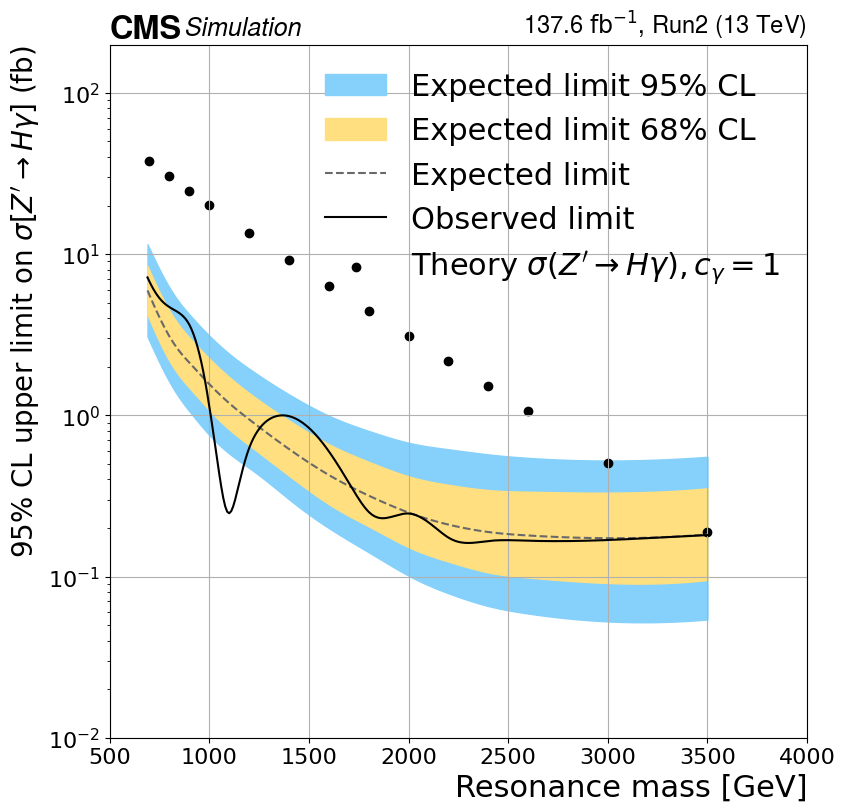

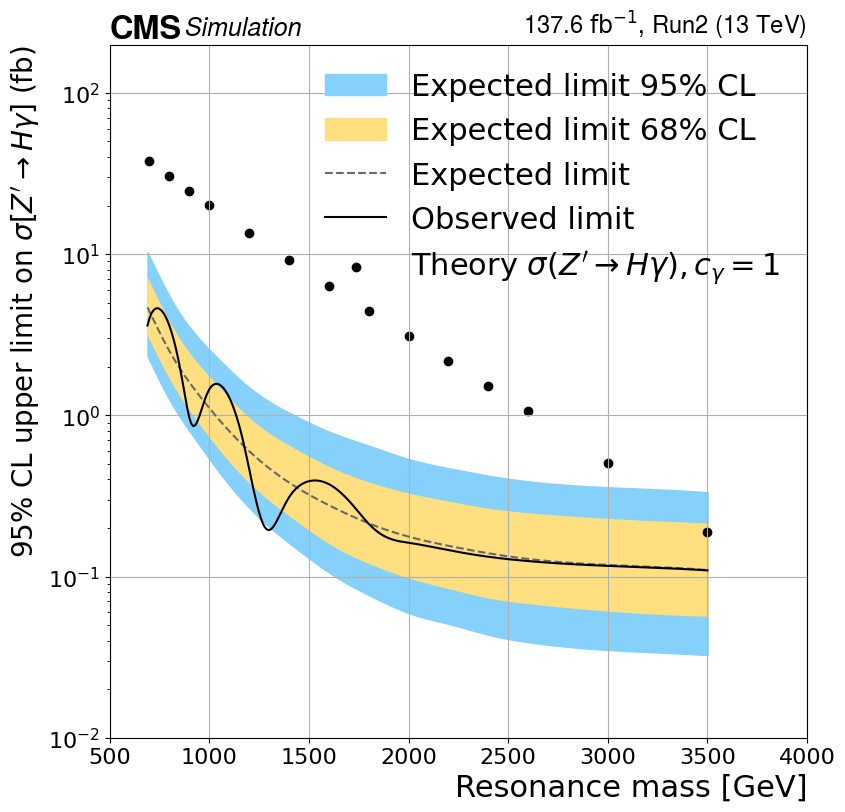

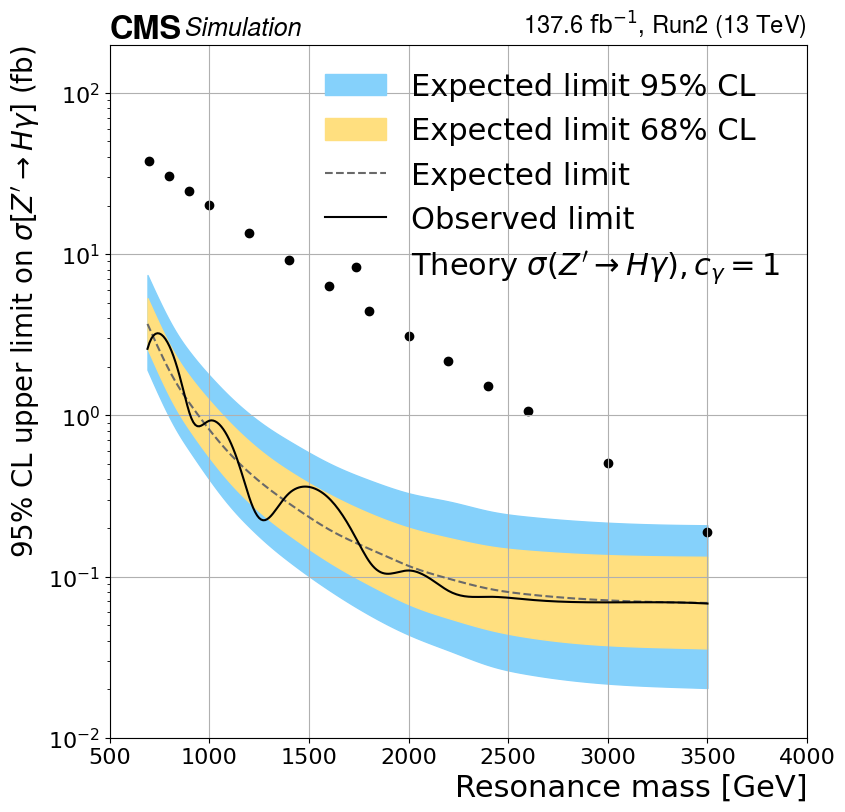

In [6]:
for SR in ['SR1', 'SR2', 'combine']:
    plot_cross_section_limit(cross_section_limit=cross_section_limit[SR], SR=SR, cross_section_nominal=cross_section_nominal, x_name='Resonance mass [GeV]', year='Run2', channel='Hbb')

### coupling_limit

In [9]:
from scipy.interpolate import CubicSpline

def plot_rate_limit(coupling_limit, SR='combine', x_name='Resonance mass [GeV]', cuts=None, year='2018', x_min=500, x_max=3800):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}

    ## canvas initializing
    # colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    f = plt.figure(figsize=(9, 9))
    ax = plt.gca()
    plt.grid()
    hep.cms.label(data=False, ax=ax, fontsize=18, year=year, lumi=LUMI[year])
    
    x = np.arange(700, 3501, 10)
        
    ## plot
    plt.fill_between(x,
        CubicSpline(MASS, [coupling_limit[m]['Expected +2sigma'] for m in MASS])(x),
        CubicSpline(MASS, [coupling_limit[m]['Expected -2sigma'] for m in MASS])(x),
        color='#85D1FBff', label='Expected limit 95% CL'
    )
    plt.fill_between(x, 
        CubicSpline(MASS, [coupling_limit[m]['Expected +1sigma'] for m in MASS])(x),
        CubicSpline(MASS, [coupling_limit[m]['Expected -1sigma'] for m in MASS])(x),
        color='#FFDF7Fff', label='Expected limit 68% CL'
    )
    plt.plot(x, CubicSpline(MASS, [coupling_limit[m]['Expected Limit'] for m in MASS])(x), color='DimGray', label='Expected limit', linestyle='dashed')
    plt.plot([x_min, x_max], [1, 1], c='black', label=r'Theory $c_\gamma=1$')

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(1e-1, ax.get_ylim()[1]*5)
    ax.set_yscale('log')
    #ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    #x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    #y_major_locator=MultipleLocator(1)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel(r'95% CL upper limit on coupling $c_\gamma$', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=22)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'../plots/fit/{year}'):
        os.makedirs(f'../plots/fit/{year}')
    plt.savefig(f"../plots/fit/{year}/{SR}_limit_coupling.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
for SR in ['SR1', 'SR2', 'combine']:
    plot_rate_limit(coupling_limit={m: {k: np.sqrt(rate_limit[SR][m][k]) for k in rate_limit[SR][m]} for m in rate_limit[SR]}, year='Run2', SR=SR)

## Zgamma

### narrow

In [ ]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]

rate_limit = {SR: {} for SR in ['SR1', 'SR2', 'combine']} 
CHANNEL = 'Zbb'
width='0p014'
for f in os.listdir('./'):
    if not (f.endswith('.root') and 'AsymptoticLimits' in f):
        continue

    mass, channel = f.split('.')[1:3]
    if '_' in mass:
        continue
    mass = int(mass.split('_')[0])
    if '_' in channel:
        channel, SR = channel.split('_')
    else:
        SR = 'combine'

    if channel != CHANNEL:
        continue

    stats = uproot.open(f'./{f}')
    limits = stats['limit']['limit'].array()
    rate_limit[SR][int(mass)] = {
        'Expected -2sigma': float(limits[0]),
        'Expected -1sigma': float(limits[1]),
        'Expected Limit': float(limits[2]),
        'Expected +1sigma': float(limits[3]),
        'Expected +2sigma': float(limits[4]),
        'Observed Limit': float(limits[5]),
    }

a = rate_limit['combine'][800]['Expected Limit']
b = rate_limit['combine'][1000]['Expected Limit']


for SR in rate_limit:
    for limit in rate_limit[SR][700]:
        #rate_limit[SR][700][limit] = 2*rate_limit[SR][700][limit] - 1*rate_limit[SR][700]['Expected Limit']
        #rate_limit[SR][900][limit] = 1.5*rate_limit[SR][900][limit] - 0.5*rate_limit[SR][900]['Expected Limit']
        rate_limit[SR][800][limit] = rate_limit[SR][800][limit]*2.5076170165587275
        rate_limit[SR][1000][limit] = rate_limit[SR][1000][limit]*1.124935642900486
        #rate_limit[SR][1200][limit] = float(np.sqrt(rate_limit[SR][1000][limit]*rate_limit[SR][1400][limit]))


with open(f'./rate_limit_{CHANNEL}.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate_limit, f)

with open(f'./rate_limit_{CHANNEL}.yaml', 'r', encoding='utf-8') as f:
    rate_limit=yaml.safe_load(f)

with open('../src/parameters/cross-section.yaml', 'r', encoding='utf-8') as f:
    cross_section_nominal = yaml.safe_load(f)['GluGluToZG']

# convert pb to fb
cross_section_nominal = {int(k.split('_M')[1].split('_')[0]): float(v)*1e3/0.7 for k, v in cross_section_nominal.items()}


cross_section_limit = {
    SR: {
        m : {
            limit: rate_limit[SR][m][limit] * cross_section_nominal[m] for limit in rate_limit[SR][m]
        } for m in MASS
    } for SR in rate_limit
}
print(rate_limit['combine'][800]['Expected Limit']/a)
print(rate_limit['combine'][1000]['Expected Limit']/b)

2.5076170165587275
1.124935642900486


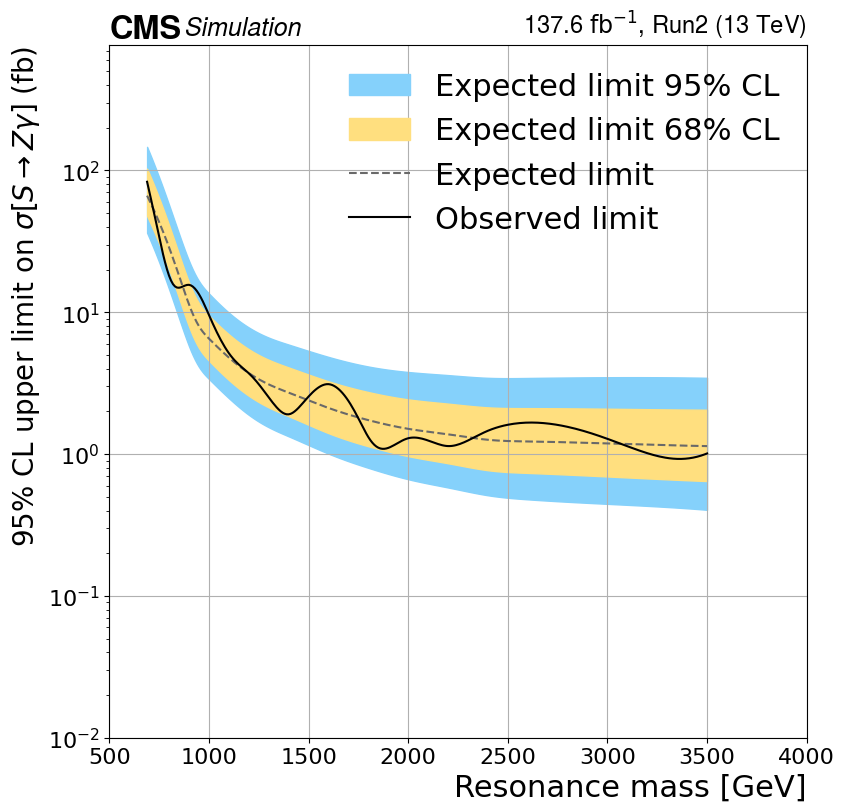

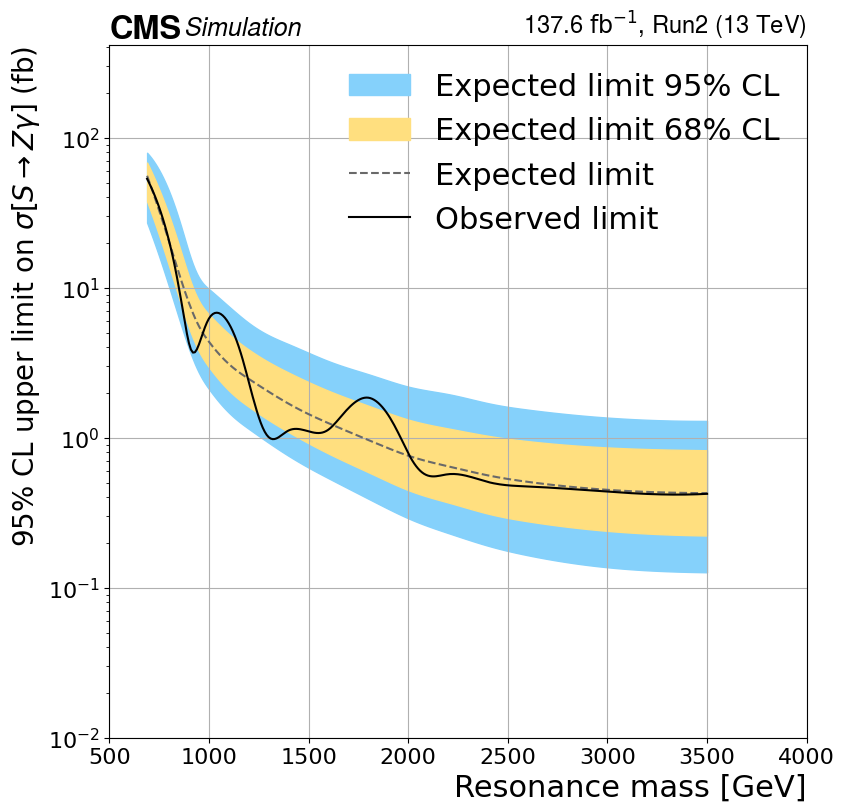

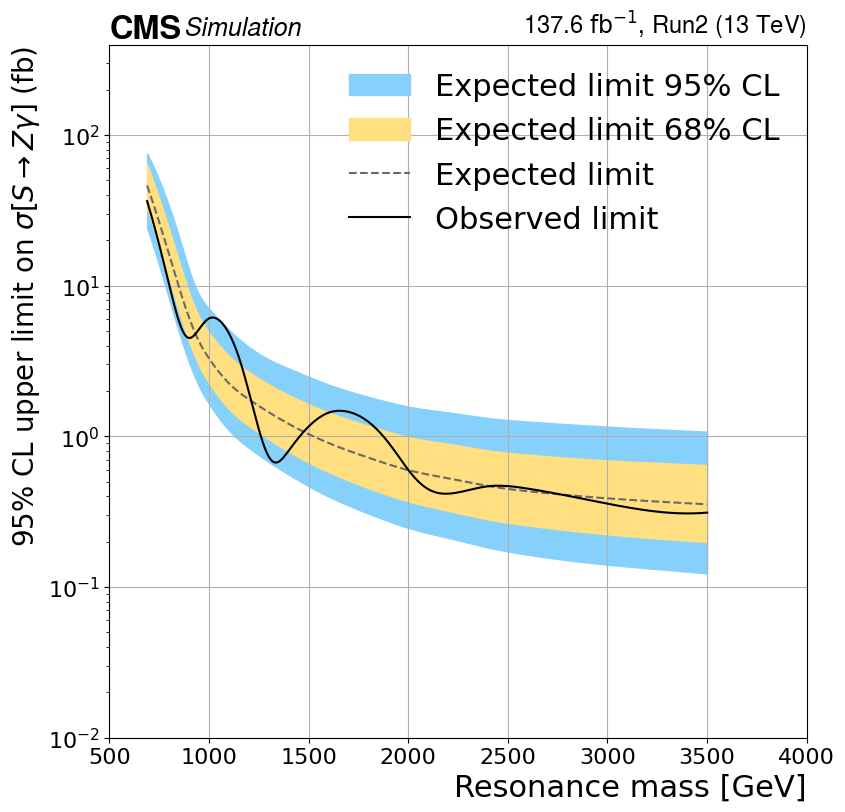

In [11]:
for SR in ['SR1', 'SR2', 'combine']:
    plot_cross_section_limit(cross_section_limit=cross_section_limit[SR], cross_section_nominal=None, SR=SR, x_name='Resonance mass [GeV]', y_name=r'$\sigma[S\to Z\gamma]$', year='Run2', channel='Zbb')

In [24]:
rate_limit['combine'][700]

{'Expected +1sigma': 41.197479248046875,
 'Expected +2sigma': 49.79104232788086,
 'Expected -1sigma': 20.8011474609375,
 'Expected -2sigma': 15.5068359375,
 'Expected Limit': 29.625,
 'Observed Limit': 23.011236310634093}

### wide

In [32]:
MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]

rate_limit = {SR: {} for SR in ['SR1', 'SR2', 'combine']} 
CHANNEL = 'Zbb'
width='5p6'
for f in os.listdir('./'):
    if not (f.endswith('.root') and 'AsymptoticLimits' in f and width in f):
        continue

    mass, channel = f.split('.')[1:3]
    mass = int(mass.split('_')[0])
    if '_' in channel:
        channel, SR = channel.split('_')
    else:
        SR = 'combine'

    if channel != CHANNEL:
        continue

    stats = uproot.open(f'./{f}')
    limits = stats['limit']['limit'].array()
    rate_limit[SR][int(mass)] = {
        'Expected -2sigma': float(limits[0]),
        'Expected -1sigma': float(limits[1]),
        'Expected Limit': float(limits[2]),
        'Expected +1sigma': float(limits[3]),
        'Expected +2sigma': float(limits[4]),
        'Observed Limit': float(limits[5]),
    }

for SR in rate_limit:
    for limit in rate_limit[SR][700]:
        continue
        #rate_limit[SR][700][limit] = 2*rate_limit[SR][700][limit] - 1*rate_limit[SR][700]['Expected Limit']
        #rate_limit[SR][900][limit] = 1.5*rate_limit[SR][900][limit] - 0.5*rate_limit[SR][900]['Expected Limit']
        #rate_limit[SR][1000][limit] = float(np.sqrt(rate_limit[SR][900][limit]*rate_limit[SR][1200][limit]))
        #rate_limit[SR][800][limit] = float(np.sqrt(rate_limit[SR][700][limit]*rate_limit[SR][900][limit]))
        #rate_limit[SR][1200][limit] = float(np.sqrt(rate_limit[SR][1000][limit]*rate_limit[SR][1400][limit]))


with open(f'./rate_limit_{CHANNEL}_{width}.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate_limit, f)

with open(f'./rate_limit_{CHANNEL}_{width}.yaml', 'r', encoding='utf-8') as f:
    rate_limit=yaml.safe_load(f)

with open('../src/parameters/cross-section.yaml', 'r', encoding='utf-8') as f:
    cross_section_nominal = yaml.safe_load(f)['GluGluToZG']

# convert pb to fb
cross_section_nominal = {int(k.split('_M')[1].split('_')[0]): float(v)*1e3/0.7 for k, v in cross_section_nominal.items()}


cross_section_limit = {
    SR: {
        m : {
            limit: rate_limit[SR][m][limit] * cross_section_nominal[m] for limit in rate_limit[SR][m]
        } for m in MASS
    } for SR in rate_limit
}
cross_section_limit['SR1'][800]['Expected Limit'], cross_section_limit['SR2'][800]['Expected Limit'], cross_section_limit['combine'][800]['Expected Limit']

(18.30357142857143, 12.633928571428571, 10.223214285714286)

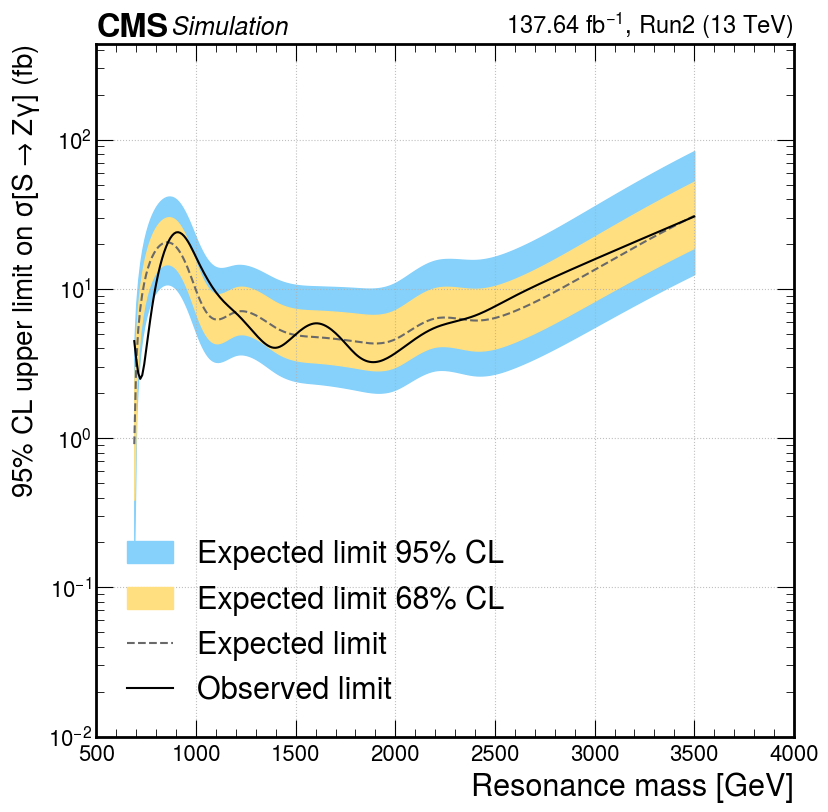

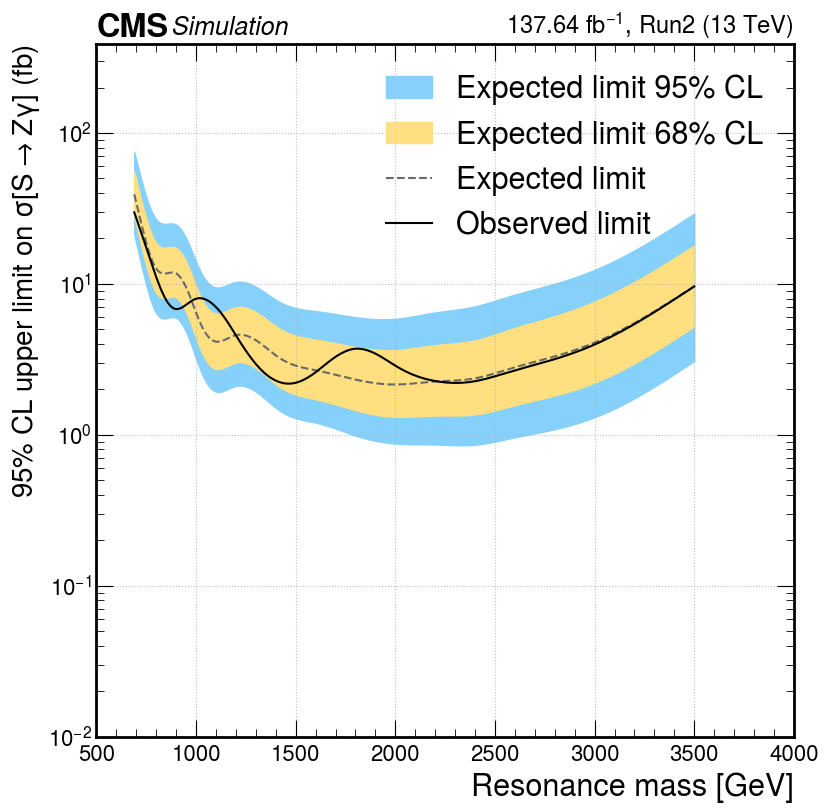

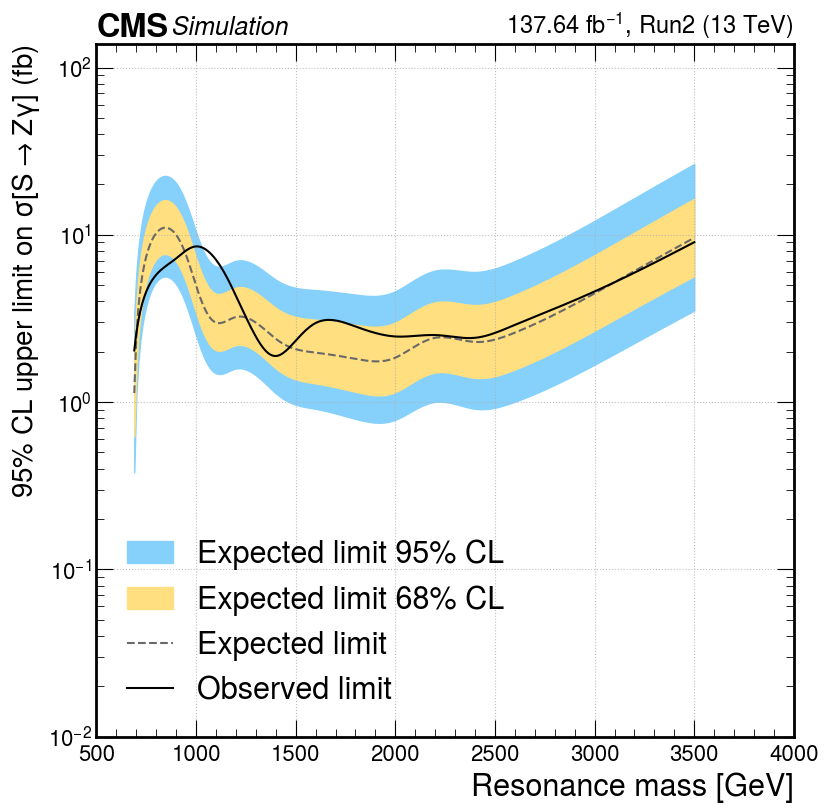

In [33]:
for SR in ['SR1', 'SR2', 'combine']:
    plot_cross_section_limit(cross_section_limit=cross_section_limit[SR], cross_section_nominal=None, SR=SR, x_name='Resonance mass [GeV]', y_name=r'$\sigma[S\to Z\gamma]$', year='Run2', channel='Zbb_5p6')

### very wide

In [35]:

rate_limit = {SR: {} for SR in ['SR1', 'SR2', 'combine']} 
CHANNEL = 'Zbb'
width='10p0'
for f in os.listdir('./'):
    if not (f.endswith('.root') and 'AsymptoticLimits' in f and width in f):
        continue

    mass, channel = f.split('.')[1:3]
    mass = int(mass.split('_')[0])
    if '_' in channel:
        channel, SR = channel.split('_')
    else:
        SR = 'combine'

    if channel != CHANNEL:
        continue

    stats = uproot.open(f'./{f}')
    limits = stats['limit']['limit'].array()
    rate_limit[SR][int(mass)] = {
        'Expected -2sigma': float(limits[0]),
        'Expected -1sigma': float(limits[1]),
        'Expected Limit': float(limits[2]),
        'Expected +1sigma': float(limits[3]),
        'Expected +2sigma': float(limits[4]),
        'Observed Limit': float(limits[5]),
    }

for SR in rate_limit:
    for limit in rate_limit[SR][700]:
        #rate_limit[SR][700][limit] = 2*rate_limit[SR][700][limit] - 1*rate_limit[SR][700]['Expected Limit']
        #rate_limit[SR][900][limit] = 1.5*rate_limit[SR][900][limit] - 0.5*rate_limit[SR][900]['Expected Limit']
        #rate_limit[SR][800][limit] = float(np.sqrt(rate_limit[SR][700][limit]*rate_limit[SR][900][limit]))
        #rate_limit[SR][1000][limit] = float(np.sqrt(rate_limit[SR][900][limit]*rate_limit[SR][1200][limit]))
        #rate_limit[SR][1400][limit] = float(np.sqrt(rate_limit[SR][1200][limit]*rate_limit[SR][1600][limit]))
        #rate_limit[SR][2400][limit] = float(np.sqrt(rate_limit[SR][2200][limit] * rate_limit[SR][2600][limit]))
        #rate_limit[SR][1800][limit] = float(np.sqrt(rate_limit[SR][1600][limit]*rate_limit[SR][2000][limit]))
        continue


with open(f'./rate_limit_{CHANNEL}_{width}.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(rate_limit, f)

with open(f'./rate_limit_{CHANNEL}_{width}.yaml', 'r', encoding='utf-8') as f:
    rate_limit=yaml.safe_load(f)

with open('../src/parameters/cross-section.yaml', 'r', encoding='utf-8') as f:
    cross_section_nominal = yaml.safe_load(f)['GluGluToZG']

# convert pb to fb
cross_section_nominal = {int(k.split('_M')[1].split('_')[0]): float(v)*1e3/0.7 for k, v in cross_section_nominal.items()}


cross_section_limit = {
    SR: {
        m : {
            limit: rate_limit[SR][m][limit] * cross_section_nominal[m] for limit in rate_limit[SR][m]
        } for m in MASS
    } for SR in rate_limit
}
cross_section_limit['SR1'][800]['Expected Limit'], cross_section_limit['SR2'][800]['Expected Limit'], cross_section_limit['combine'][800]['Expected Limit']

(25.580357142857142, 16.830357142857142, 13.928571428571429)

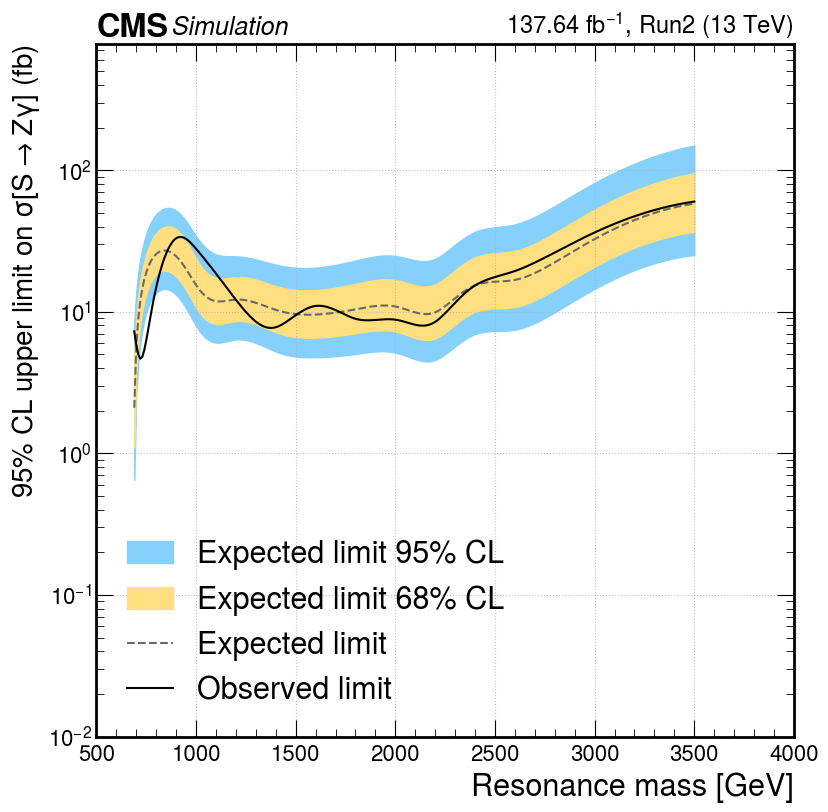

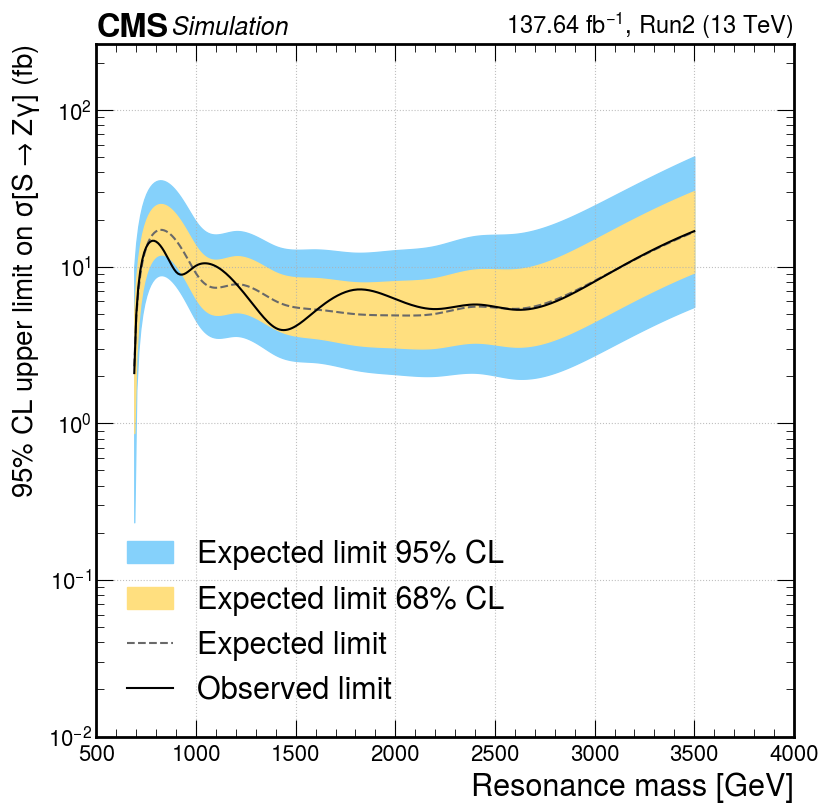

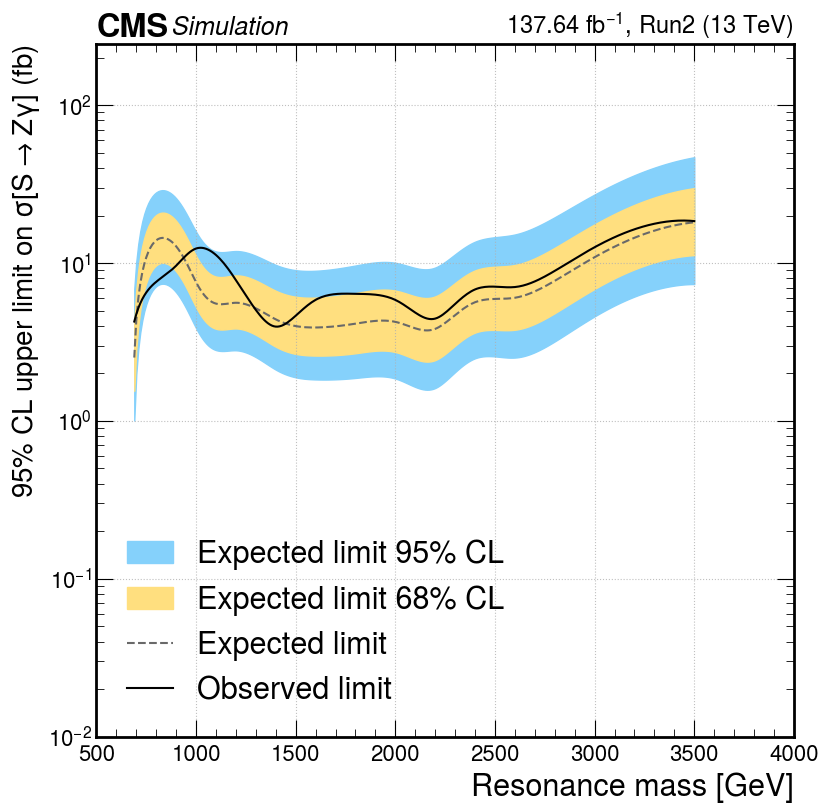

In [36]:
for SR in ['SR1', 'SR2', 'combine']:
    plot_cross_section_limit(cross_section_limit=cross_section_limit[SR], cross_section_nominal=None, SR=SR, x_name='Resonance mass [GeV]', y_name=r'$\sigma[S\to Z\gamma]$', year='Run2', channel='Zbb_10p0')